<a href="https://colab.research.google.com/github/MattJCR/APRENDIZAJE-NO-SUPERVISADO-KMEANS/blob/master/APRENDIZAJE_NO_SUPERVISADO_KMEANS_Segmentaci%C3%B3n_de_clientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descripción de la tarea 

Realizar estudios exploratorios de los datos usando análisis cluster y empleando el algoritmo de Kmeans o K-medias. Para ello habrá que: 
* Preprocesar los datos. En esta etapa se seleccionarán las variables que sean relevantes, detectará los outliers y observaciones relevantes. 
* Análisis cluster. Se determinará cuántos grupos significativos se pueden encontrar en los datos y se calcularán. 
* Realizar una descripción semántica de los patrones encontrados. analizando la importancia de cada grupo y analizando la importancia de las variables en su definición, para ello hay que realizar una descripción estadística de los grupos encontrados. 

## Segmentación de clientes 
https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python
* En el dataset se encuentran datos relativos a clientes de un centro comercial (género, edad, ingresos anuales, puntuación de gasto (asignada por el centro comercial)) 
* El objetivo es categorizar los clientes

Ideas de visualización:
https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57 

In [ ]:
#@title Importación de librerías
import pandas as pd
import time
import urllib.request
import tempfile
import seaborn as sns
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#@title Obtención del dataset

# URL del archivo CSV en GitHub
# https://www.kaggle.com/datasets/thedevastator/european-day-ahead-market-power-prices-by-hour

url = 'https://raw.githubusercontent.com/MattJCR/APRENDIZAJE-NO-SUPERVISADO-KMEANS/master/dataset/Mall_Customers.csv'
dfs = []

# Descargar el archivos CSV

response = urllib.request.urlopen(url)

# Crear un archivo temporal para guardar el archivo CSV descargado
temp = tempfile.NamedTemporaryFile()

# Escribir los datos descargados en el archivo temporal
temp.write(response.read())

# Mover el puntero al inicio del archivo
temp.seek(0)

# Cargar el archivo CSV en un DataFrame
df = pd.read_csv(temp, index_col='CustomerID')

# Cerrar el archivo temporal
temp.close()
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [ ]:
df.rename(columns={'Gender':'gender',
                   'Age':'age',
                   'Annual Income (k$)':'annual_income',
                   'Spending Score (1-100)':'score'
                   },
               inplace=True)
df.columns

Index(['gender', 'age', 'annual_income', 'score'], dtype='object')

# Preprocesamiento y elección de variables relevantes para el estudio.

In [ ]:
df.isnull().sum()

gender           0
age              0
annual_income    0
score            0
dtype: int64

In [ ]:
df.describe()

,age,annual_income,score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


En este caso no se va a realizar ninguna selección de columnas ya que son pocas y ya están preparadas para el entrenamiento.

Una vez tenemos los datos limpios y preparados para trabajar con ellos vamos a proceder a tratar los datos categoricos.
Vamos a utilizar un encoder llamado OneHotEncoder. Esta clase de scikit-learn codifica variables categóricas en una representación binaria utilizando una codificación "one-hot".

Primero obtenemos las columnas que son categoricas:

In [ ]:
categorical = list(set(df.columns) - set(df._get_numeric_data().columns))
categorical

['gender']

In [ ]:
# Inicializar el codificador one-hot
encoder = OneHotEncoder()

# Ajusta y transforma la columna categórica en una matriz de codificación one-hot
one_hot = encoder.fit_transform(df[categorical]).toarray()

# Crea un dataframe a partir de la matriz de codificación one-hot
one_hot_df = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(categorical))
one_hot_df = one_hot_df.astype(bool)
# Eliminar la columna categórica original
df = df.drop(columns=categorical)
one_hot_df

,gender_Female,gender_Male
0,False,True
1,False,True
2,True,False
3,True,False
4,True,False
...,...,...
195,True,False
196,True,False
197,False,True
198,False,True


In [ ]:
df

,age,annual_income,score
CustomerID,,,
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
...,...,...,...
196,35,120,79
197,45,126,28
198,32,126,74


In [ ]:
df['CustomerID'] = df.index
one_hot_df['CustomerID'] = df['CustomerID']
one_hot_df = one_hot_df.set_index(df['CustomerID'])
df = df.join(one_hot_df, lsuffix='_left', rsuffix='_right')
df = df.drop(columns=['CustomerID_left','CustomerID_right'])

In [ ]:
df.gender_Female = df.gender_Female.replace({True: 1, False: 0})
df.gender_Male = df.gender_Male.replace({True: 1, False: 0})
df

,age,annual_income,score,gender_Female,gender_Male
CustomerID,,,,,
1,19,15,39,0,1
2,21,15,81,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0
...,...,...,...,...,...
196,35,120,79,1,0
197,45,126,28,1,0
198,32,126,74,0,1


<Axes: >

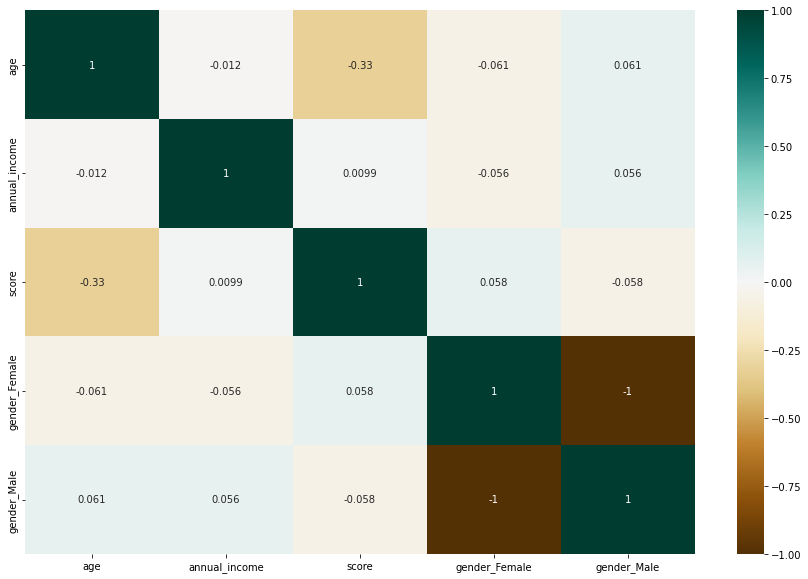

In [ ]:
# Calcular la correlación entre las variables del DataFrame
corr = df.corr()

# Mostrar el mapa de calor de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap = 'BrBG', annot = True)

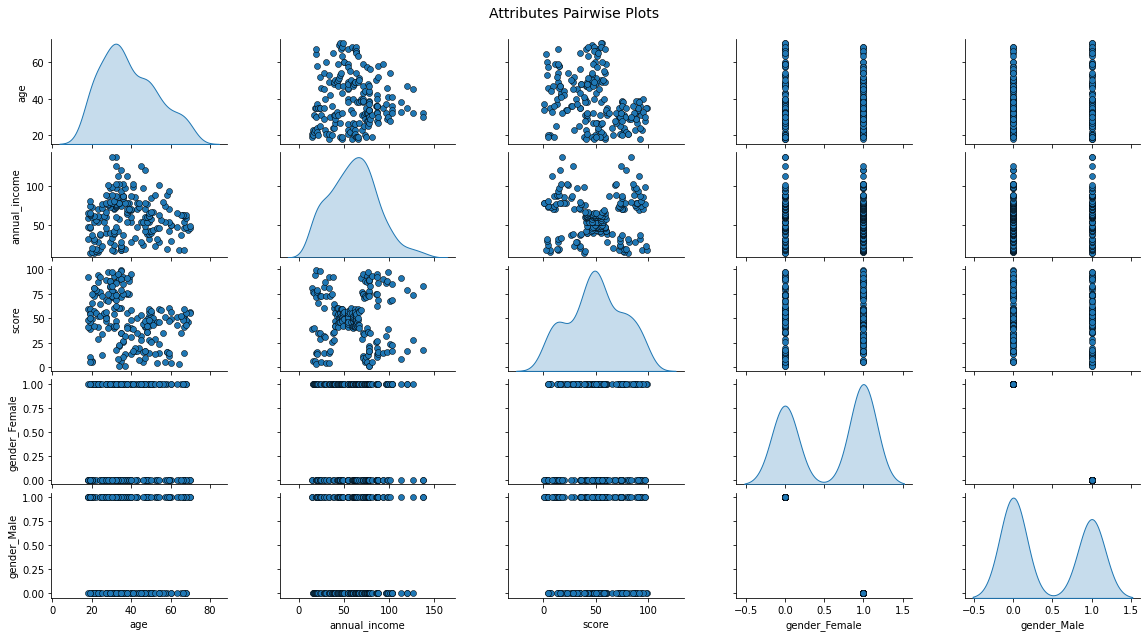

In [ ]:
cols = list(df.columns)
pp = sns.pairplot(df[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Attributes Pairwise Plots', fontsize=14)

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'annual_income'}>],
       [<Axes: title={'center': 'score'}>,
        <Axes: title={'center': 'gender_Female'}>],
       [<Axes: title={'center': 'gender_Male'}>, <Axes: >]], dtype=object)

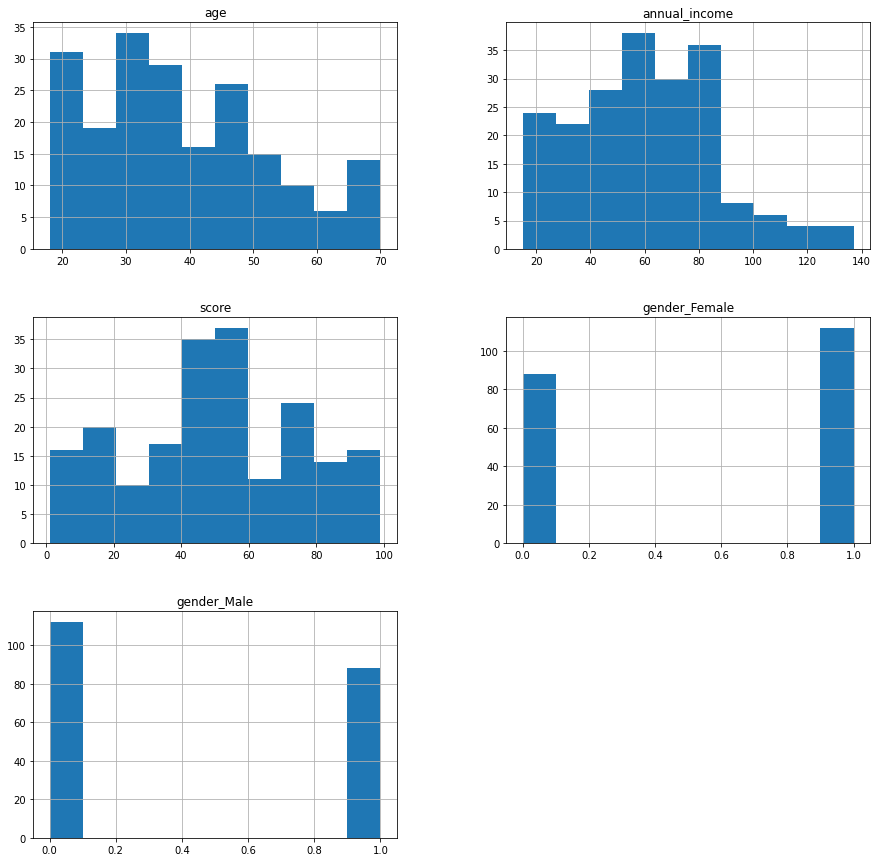

In [ ]:
df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())

In [ ]:
df

,age,annual_income,score,gender_Female,gender_Male
CustomerID,,,,,
1,19,15,39,0,1
2,21,15,81,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0
...,...,...,...,...,...
196,35,120,79,1,0
197,45,126,28,1,0
198,32,126,74,0,1


# Escalamiento y detección de outliers 

* Argumentar si es necesario o no realizar escalamiento de las variables, y, si es necesario, escalarlas. 

En este caso no es necesario realizar el escalamiento.


In [ ]:
# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  plt.clf()  # borra la figura anterior
  sns.boxplot(x = feature_name, data = df)
  sns.stripplot(x = feature_name, data = df, color = "#474646")
  plt.show()  # muestra la nueva figura creada

In [ ]:
df.columns

Index(['age', 'annual_income', 'score', 'gender_Female', 'gender_Male'], dtype='object')

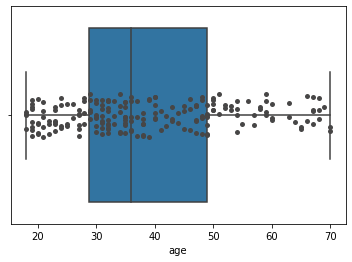

In [ ]:
draw_hist_boxplot(df, 'age')

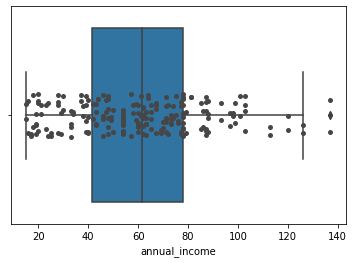

In [ ]:
draw_hist_boxplot(df, 'annual_income')

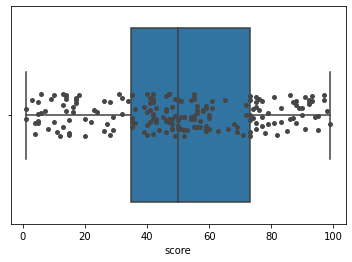

In [ ]:
draw_hist_boxplot(df, 'score')

* Detectar los outliers y eliminarlos utilizando el método de Jacknife en el que ejecutaremos el algoritmo K-means eliminando una observación cada vez. 

* Almacenaremos el índice SSE de cada una de las ejecuciones en un vector. Esa información se puede obtener con la variable inertia_ del modelo 


In [ ]:
# Convertir dataframe a matriz numpy
X = df.to_numpy()

# Definir parámetros del algoritmo K-means
N = X.shape[0]
K = 4

# Ejecutar el algoritmo K-means con el método de Jacknife
SSE = []
for i in range(0, N):
    X_sin_i = np.delete(X, i, axis=0)
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=100).fit(X_sin_i)
    SSE.append(kmeans.inertia_)

SSE[:5]

[102943.9055780477,
 104205.23891138105,
 101399.51373808744,
 104283.75742989956,
 103239.3453170348]

In [ ]:
# Calcular el umbral para detectar outliers
sigma = np.std(SSE)
mu = np.mean(SSE)
umbral = 2

# Identificar los outliers
outliers = []
for i in range(0, N):
    if np.abs(SSE[i]-mu) > umbral*sigma:
        outliers.append(i)
print(f"Numero de outliers:{len(outliers)}")
outliers

Numero de outliers:13


[2, 6, 8, 10, 12, 14, 22, 30, 32, 196, 197, 198, 199]

In [ ]:
# Eliminar los outliers del dataframe
df = df.drop(outliers)

# Imprimir el dataframe sin los outliers
df

,age,annual_income,score,gender_Female,gender_Male
CustomerID,,,,,
1,19,15,39,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0
7,35,18,6,1,0
...,...,...,...,...,...
192,32,103,69,1,0
193,33,113,8,0,1
194,38,113,91,1,0


* Ejecución de análisis cluster con un valor de k concreto (número de grupos), por ejemplo 4, y determinar el número de réplicas (n_init) del algoritmo que conduce a que la repetición de dicho algoritmo genere la misma solución.

In [ ]:
# importar KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init = 10, random_state=1)

# entrenamiento (ajustar el modelo)
kmeans.fit(df)
labels = kmeans.labels_

# prediccion -> devuelve array con el número de grupo al que pretenece cada dato
pred = kmeans.predict(df) # También puede utilizarse kmeans.fit_predict(X) realiza ambas etapas

# obtener centroides de los grupos
centroides = kmeans.cluster_centers_
print(centroides)

pred

[[45.2173913  26.30434783 20.91304348  0.60869565  0.39130435]
 [40.61538462 50.93406593 54.02197802  0.57142857  0.42857143]
 [32.64864865 84.56756757 82.43243243  0.54054054  0.45945946]
 [40.5        84.52777778 18.38888889  0.47222222  0.52777778]]


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2], dtype=int32)

In [ ]:
import plotly.express as px
df_plotly = df.copy()
df_plotly['label'] =  labels
fig = px.scatter_3d(df_plotly, x='age', y='score', z='annual_income',
              color='label')
fig.show()

Determinar el valor de k (número de grupos) 

Optimizando la función BIC

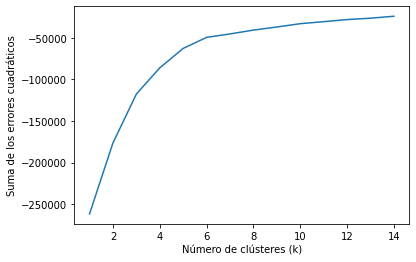

In [ ]:
# Curva elbow para determinar valor óptimo de k.
nc = range(1, 15) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df).score(df) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

In [ ]:
from sklearn.mixture import GaussianMixture
def get_bic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return k, gmm.bic(X)

In [ ]:
bic_score = pd.DataFrame([get_bic(k, X) for k in range(2, 15)], columns=['k', 'BIC'])
bic_score

,k,BIC
0,2,3454.308701
1,3,3532.362107
2,4,3499.606979
3,5,3543.157825
4,6,3610.764117
5,7,3703.535095
6,8,3768.093183
7,9,3838.355792
8,10,1425.596409
9,11,3954.161082


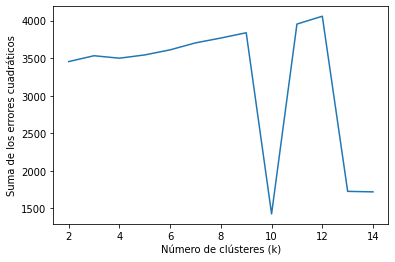

In [ ]:
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(bic_score['k'],bic_score['BIC'])

In [ ]:
k_optimized = bic_score[bic_score.BIC == bic_score.BIC.min()]
k_optimized

,k,BIC
8,10,1425.596409


In [ ]:
k = k_optimized['k'].values[0]

Ejecución de análisis con los datos calculados (k y n_init)

In [ ]:
# importar KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, n_init = 10, random_state=1)

# entrenamiento (ajustar el modelo)
kmeans.fit(df)
labels = kmeans.labels_

# prediccion -> devuelve array con el número de grupo al que pretenece cada dato
pred = kmeans.predict(df) # También puede utilizarse kmeans.fit_predict(X) realiza ambas etapas

# obtener centroides de los grupos
centroides = kmeans.cluster_centers_
print(centroides)

pred

[[ 24.17241379  57.44827586  49.62068966   0.62068966   0.37931034]
 [ 32.22222222 104.88888889  84.11111111   0.55555556   0.44444444]
 [ 45.875       94.8125      22.5          0.5625       0.4375    ]
 [ 63.90909091  53.04545455  50.63636364   0.45454545   0.54545455]
 [ 37.5         29.33333333  34.58333333   0.66666667   0.33333333]
 [ 25.92857143  29.57142857  76.78571429   0.5          0.5       ]
 [ 32.78571429  78.03571429  81.89285714   0.53571429   0.46428571]
 [ 37.8125      77.3125      10.25         0.3125       0.6875    ]
 [ 46.55172414  56.37931034  47.48275862   0.65517241   0.34482759]
 [ 48.75        24.58333333   9.58333333   0.58333333   0.41666667]]


array([4, 9, 5, 4, 9, 9, 9, 9, 9, 5, 4, 5, 4, 5, 4, 9, 5, 9, 5, 4, 5, 4,
       9, 9, 5, 9, 5, 9, 5, 4, 5, 3, 5, 4, 5, 4, 5, 8, 0, 4, 4, 8, 0, 0,
       3, 8, 8, 8, 3, 0, 8, 3, 0, 3, 3, 3, 0, 8, 3, 0, 0, 3, 8, 3, 3, 3,
       0, 8, 8, 0, 8, 3, 8, 3, 8, 0, 8, 3, 0, 0, 8, 3, 0, 8, 8, 0, 0, 8,
       0, 8, 0, 0, 8, 3, 0, 8, 0, 3, 8, 3, 3, 3, 0, 8, 0, 0, 0, 3, 8, 8,
       8, 0, 8, 8, 6, 0, 6, 8, 6, 7, 6, 7, 6, 0, 6, 7, 6, 7, 6, 7, 6, 7,
       6, 0, 6, 7, 6, 2, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 2, 6, 7,
       6, 2, 6, 2, 6, 2, 6, 7, 6, 7, 6, 2, 6, 2, 6, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1], dtype=int32)

In [ ]:
import plotly.express as px
df['label'] =  labels
fig = px.scatter_3d(df, x='age', y='score', z='annual_income',
              color='label')
fig.show()

In [ ]:
df

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
1,19,15,39,0,1,4
3,20,16,6,1,0,9
4,23,16,77,1,0,5
5,31,17,40,1,0,4
7,35,18,6,1,0,9
...,...,...,...,...,...,...
192,32,103,69,1,0,1
193,33,113,8,0,1,2
194,38,113,91,1,0,1


Mostrar para el análisis anterior una tabla con los siguientes datos: número de grupo, cantidad de observaciones de ese grupo y el centroide que representa a ese grupo(valor de cada variable) 

Esta tabla podría ser una tabla de pandas

In [ ]:
group = df.groupby(['label']).count() 
group

,age,annual_income,score,gender_Female,gender_Male
label,,,,,
0,29,29,29,29,29
1,9,9,9,9,9
2,16,16,16,16,16
3,22,22,22,22,22
4,12,12,12,12,12
5,14,14,14,14,14
6,28,28,28,28,28
7,16,16,16,16,16
8,29,29,29,29,29


In [ ]:
result = []

for idx, x in enumerate(centroides):
    # print(x)
    row = [
        idx, 
        group.loc[[idx]]['age'].values[0],
        x[0],
        x[1],
        x[2],
        x[3],
        x[4]
    ]
    result.append(row)
result = pd.DataFrame(result,columns=['grupo', 'values','center_age','center_annual_income','center_score','center_gender_Female','center_gender_Male'])
result

,grupo,values,center_age,center_annual_income,center_score,center_gender_Female,center_gender_Male
0,0,29,24.172414,57.448276,49.620690,0.620690,0.379310
1,1,9,32.222222,104.888889,84.111111,0.555556,0.444444
2,2,16,45.875000,94.812500,22.500000,0.562500,0.437500
3,3,22,63.909091,53.045455,50.636364,0.454545,0.545455
4,4,12,37.500000,29.333333,34.583333,0.666667,0.333333
5,5,14,25.928571,29.571429,76.785714,0.500000,0.500000
6,6,28,32.785714,78.035714,81.892857,0.535714,0.464286
7,7,16,37.812500,77.312500,10.250000,0.312500,0.687500
8,8,29,46.551724,56.379310,47.482759,0.655172,0.344828
9,9,12,48.750000,24.583333,9.583333,0.583333,0.416667


Realiza una descripción semántica de los grupos

Explicación de las características más relevantes de cada grupo (para ayudarte a explicar los grupos realiza un análisis estadístico de los resultados)

In [ ]:
#@title GRUPO 0
df[df['label'] == 0].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
48,27,40,47,1,0,0
52,33,42,60,0,1,0
53,31,43,54,1,0,0
59,27,46,51,1,0,0
62,19,46,55,0,1,0


In [ ]:
df[df['label'] == 0].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,24.172414,57.448276,49.620690,0.620690,0.379310,0.0
std,4.971842,9.272025,7.793834,0.493804,0.493804,0.0
min,18.000000,40.000000,29.000000,0.000000,0.000000,0.0
25%,19.000000,48.000000,46.000000,0.000000,0.000000,0.0
50%,23.000000,60.000000,51.000000,1.000000,0.000000,0.0
75%,27.000000,63.000000,55.000000,1.000000,1.000000,0.0
max,34.000000,76.000000,60.000000,1.000000,1.000000,0.0


El grupo 0 está compuesto por clientes (62% mujeres y 38% hombres).

Tienen un score entre 29-60 y una media de 49,6.

Su salario anual se estima en una media de 57K y está entre 40K y 76K.

Se podria definir como un grupo de personas principalmente mujeres de clase media-alta con un potencial medio en compras.

In [ ]:
#@title GRUPO 1
df[df['label'] == 1].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
180,35,93,90,0,1,1
182,32,97,86,1,0,1
184,29,98,88,1,0,1
186,30,99,97,0,1,1
188,28,101,68,0,1,1


In [ ]:
df[df['label'] == 1].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,32.222222,104.888889,84.111111,0.555556,0.444444,1.0
std,3.419714,13.251834,9.726824,0.527046,0.527046,0.0
min,28.000000,93.000000,68.000000,0.000000,0.000000,1.0
25%,30.000000,98.000000,83.000000,0.000000,0.000000,1.0
50%,32.000000,101.000000,86.000000,1.000000,0.000000,1.0
75%,35.000000,103.000000,90.000000,1.000000,1.000000,1.0
max,38.000000,137.000000,97.000000,1.000000,1.000000,1.0


El grupo 1 está compuesto por clientes (56% mujeres y 44% hombres).

Tienen un score entre 68-97 y una media de 84.

Su salario anual se estima en una media de 105K y está entre 93K y 137K.

Se podria definir como un grupo de personas de clase alta con gran potencial de compras.

In [ ]:
#@title GRUPO 2
df[df['label'] == 2].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
147,48,77,36,0,1,2
161,56,79,35,1,0,2
165,50,85,26,0,1,2
167,42,86,20,0,1,2
169,36,87,27,1,0,2


In [ ]:
df[df['label'] == 2].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.0
mean,45.875000,94.812500,22.500000,0.562500,0.437500,2.0
std,8.539126,11.742906,9.309493,0.512348,0.512348,0.0
min,33.000000,77.000000,8.000000,0.000000,0.000000,2.0
25%,40.000000,86.750000,15.000000,0.000000,0.000000,2.0
50%,46.500000,95.000000,21.500000,1.000000,0.000000,2.0
75%,52.500000,101.500000,28.250000,1.000000,1.000000,2.0
max,59.000000,120.000000,39.000000,1.000000,1.000000,2.0


El grupo 2 está compuesto por clientes (56% mujeres y 44% hombres).

Tienen un score entre 8-39 y una media de 22.

Su salario anual se estima en una media de 95K y está entre 77K y 120K.

Se podria definir como un grupo de personas de clase alta con poco potencial en compras.

In [ ]:
#@title GRUPO 3
df[df['label'] == 3].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
41,65,38,35,1,0,3
54,59,43,60,0,1,3
58,69,44,46,0,1,3
61,70,46,56,0,1,3
63,67,47,52,1,0,3


In [ ]:
df[df['label'] == 3].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.0
mean,63.909091,53.045455,50.636364,0.454545,0.545455,3.0
std,4.859052,7.840537,6.499417,0.509647,0.509647,0.0
min,54.000000,38.000000,35.000000,0.000000,0.000000,3.0
25%,60.000000,47.250000,47.250000,0.000000,0.000000,3.0
50%,65.500000,52.000000,51.000000,0.000000,1.000000,3.0
75%,67.750000,61.250000,55.750000,1.000000,1.000000,3.0
max,70.000000,65.000000,60.000000,1.000000,1.000000,3.0


El grupo 3 está compuesto por clientes (45% mujeres y 55% hombres).

Tienen un score entre 35-60 y una media de 50.

Su salario anual se estima en una media de 53K y está entre 38K y 65K.

Se podria definir como un grupo de personas de clase media con un potencial medio en compras.

In [ ]:
#@title GRUPO 4
df[df['label'] == 4].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
1,19,15,39,0,1,4
5,31,17,40,1,0,4
17,35,21,35,1,0,4
19,52,23,29,0,1,4
21,35,24,35,0,1,4


In [ ]:
df[df['label'] == 4].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,12.00000,12.000000,12.000000,12.000000,12.000000,12.0
mean,37.50000,29.333333,34.583333,0.666667,0.333333,4.0
std,9.67189,9.393744,5.468228,0.492366,0.492366,0.0
min,19.00000,15.000000,26.000000,0.000000,0.000000,4.0
25%,31.00000,22.500000,30.500000,0.000000,0.000000,4.0
50%,35.50000,28.500000,35.000000,1.000000,0.000000,4.0
75%,45.75000,39.000000,39.250000,1.000000,1.000000,4.0
max,52.00000,40.000000,42.000000,1.000000,1.000000,4.0


El grupo 4 está compuesto por clientes (67% mujeres y 33% hombres).

Tienen un score entre 26-42 y una media de 34.

Su salario anual se estima en una media de 29K y está entre 15K y 40K.

Se podria definir como un grupo de personas principalmente mujeres de clase media-baja con un potencial en compras medio-bajo.

In [ ]:
#@title GRUPO 5
df[df['label'] == 5].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
4,23,16,77,1,0,5
16,22,20,79,0,1,5
18,20,21,66,0,1,5
20,35,23,98,1,0,5
24,31,25,73,0,1,5


In [ ]:
df[df['label'] == 5].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.0
mean,25.928571,29.571429,76.785714,0.500000,0.500000,5.0
std,5.757461,7.673273,11.596940,0.518875,0.518875,0.0
min,18.000000,16.000000,61.000000,0.000000,0.000000,5.0
25%,21.250000,23.500000,67.750000,0.000000,0.000000,5.0
50%,24.000000,30.500000,76.000000,0.500000,0.500000,5.0
75%,30.750000,36.250000,81.750000,1.000000,1.000000,5.0
max,35.000000,39.000000,98.000000,1.000000,1.000000,5.0


El grupo 5 está compuesto por clientes (50% mujeres y 50% hombres).

Tienen un score entre 61-98 y una media de 78.

Su salario anual se estima en una media de 29K y está entre 16K y 39K.

Se podria definir como un grupo de personas de clase medio-baja con un alto potencial en compras.

In [ ]:
#@title GRUPO 6
df[df['label'] == 6].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
124,39,69,91,0,1,6
126,31,70,77,1,0,6
128,40,71,95,0,1,6
130,38,71,75,0,1,6
132,39,71,75,0,1,6


In [ ]:
df[df['label'] == 6].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,32.785714,78.035714,81.892857,0.535714,0.464286,6.0
std,3.975454,6.009142,9.550409,0.507875,0.507875,0.0
min,27.000000,69.000000,63.000000,0.000000,0.000000,6.0
25%,30.000000,73.000000,74.750000,0.000000,0.000000,6.0
50%,32.000000,78.000000,80.500000,1.000000,0.000000,6.0
75%,36.000000,82.000000,90.250000,1.000000,1.000000,6.0
max,40.000000,88.000000,97.000000,1.000000,1.000000,6.0


El grupo 6 está compuesto por clientes (54% mujeres y 46% hombres).

Tienen un score entre 63-97 y una media de 81.

Su salario anual se estima en una media de 78K y está entre 69K y 88K.

Se podria definir como un grupo de personas de clase medio-alta con un gran potencial en compras.

In [ ]:
#@title GRUPO 7
df[df['label'] == 7].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
129,59,71,11,0,1,7
131,47,71,9,0,1,7
135,20,73,5,0,1,7
137,44,73,7,1,0,7
139,19,74,10,0,1,7


In [ ]:
df[df['label'] == 7].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.0
mean,37.812500,77.312500,10.250000,0.312500,0.687500,7.0
std,12.426953,4.742977,6.266312,0.478714,0.478714,0.0
min,19.000000,71.000000,1.000000,0.000000,0.000000,7.0
25%,31.750000,73.750000,5.000000,0.000000,0.000000,7.0
50%,38.500000,78.000000,10.000000,0.000000,1.000000,7.0
75%,44.750000,78.000000,13.750000,1.000000,1.000000,7.0
max,59.000000,87.000000,22.000000,1.000000,1.000000,7.0


El grupo 7 está compuesto por clientes (31% mujeres y 69% hombres).

Tienen un score entre 1-22 y una media de 10.

Su salario anual se estima en una media de 77K y está entre 71K y 87K.

Se podria definir como un grupo de personas principalmente hombres de clase medio-alta con un potencial nulo en compras.

In [ ]:
#@title GRUPO 8
df[df['label'] == 8].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
47,50,40,55,1,0,8
51,49,42,52,1,0,8
55,50,43,45,1,0,8
56,47,43,41,0,1,8
57,51,44,50,1,0,8


In [ ]:
df[df['label'] == 8].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.0
mean,46.551724,56.379310,47.482759,0.655172,0.344828,8.0
std,4.618180,8.997673,6.162216,0.483725,0.483725,0.0
min,38.000000,40.000000,35.000000,0.000000,0.000000,8.0
25%,43.000000,49.000000,42.000000,0.000000,0.000000,8.0
50%,48.000000,58.000000,46.000000,1.000000,0.000000,8.0
75%,50.000000,63.000000,52.000000,1.000000,1.000000,8.0
max,54.000000,71.000000,59.000000,1.000000,1.000000,8.0


El grupo 8 está compuesto por clientes (66% mujeres y 34% hombres).

Tienen un score entre 35-59 y una media de 47.

Su salario anual se estima en una media de 56K y está entre 40K y 71K.

Se podria definir como un grupo de personas principalmente mujeres de clase medio-alta con un potencial medio en compras.

In [ ]:
#@title GRUPO 9
df[df['label'] == 9].head()

,age,annual_income,score,gender_Female,gender_Male,label
CustomerID,,,,,,
3,20,16,6,1,0,9
7,35,18,6,1,0,9
9,64,19,3,0,1,9
11,67,19,14,0,1,9
13,58,20,15,1,0,9


In [ ]:
df[df['label'] == 9].describe()

,age,annual_income,score,gender_Female,gender_Male,label
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,48.750000,24.583333,9.583333,0.583333,0.416667,9.0
std,13.585587,6.694072,5.282188,0.514929,0.514929,0.0
min,20.000000,16.000000,3.000000,0.000000,0.000000,9.0
25%,40.750000,19.000000,4.750000,0.000000,0.000000,9.0
50%,51.000000,22.500000,9.500000,1.000000,0.000000,9.0
75%,58.500000,30.750000,14.000000,1.000000,1.000000,9.0
max,67.000000,34.000000,17.000000,1.000000,1.000000,9.0


El grupo 9 está compuesto por clientes (58% mujeres y 42% hombres).

Tienen un score entre 3-17 y una media de 10.

Su salario anual se estima en una media de 24K y está entre 16K y 34K.

Se podria definir como un grupo de personas de clase medio-baja con un potencial en compras nulo.